# <center style='color:red'>Conditional Variational AutoEncoder (`Cond_VAE`) - Example using `MNIST` dataset</center>

# 1. Import required libraries

In [1]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117


# 2. Define the device

In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


# 3. Load `MNIST` dataset 

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

In [5]:
# check the length of training and test datasets

print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 60000
Length of the test dataset: 10000


In [6]:
# check the shape of training and test datasets

print('Shape of the training dataset:', training_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: torch.Size([60000, 28, 28])
Shape of the test dataset: torch.Size([10000, 28, 28])


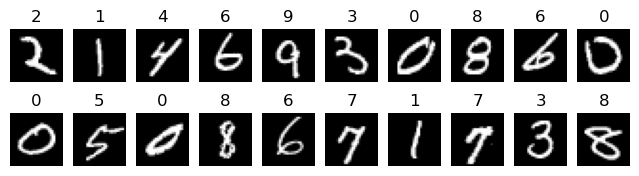

In [7]:
# show 20 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=2, ncols=10, figsize=(8, 2))

for ax, _ in zip(axis.ravel(), range(20)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

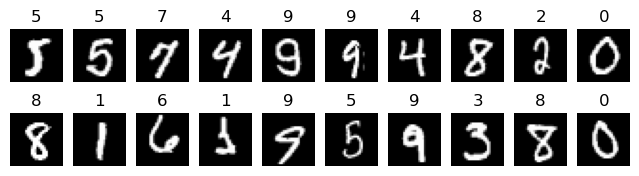

In [8]:
# show 20 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=2, ncols=10, figsize=(8, 2))

for ax, _ in zip(axis.ravel(), range(20)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

# 4. Define dataloaders

In [9]:
training_dataloader = DataLoader(training_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
# check the length of training and test dataloaders

print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 3750
Length of the test dataloader: 625


# 5. Define the network (`Cond_VAE`) architecture

In [11]:
class Cond_VAE(nn.Module):
    def __init__(self, bottleneck_dim=16, num_classes=10):
        super(Cond_VAE, self).__init__()
        
        self.bottleneck_dim = bottleneck_dim
        self.num_classes = num_classes
        self.embedding = nn.Embedding(num_embeddings=self.num_classes, embedding_dim=self.bottleneck_dim)
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor1', nn.BatchNorm2d(num_features=32))
        self.encoder.add_module('relu1', nn.ReLU(inplace=True))
        self.encoder.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor2', nn.BatchNorm2d(num_features=64))
        self.encoder.add_module('relu2', nn.ReLU(inplace=True))
        self.encoder.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor3', nn.BatchNorm2d(num_features=128))
        self.encoder.add_module('relu3', nn.ReLU(inplace=True))
        self.encoder.add_module('flat3', nn.Flatten())
        
        self._mu = nn.Linear(in_features=1152+self.bottleneck_dim, out_features=self.bottleneck_dim)
        self._logvar = nn.Linear(in_features=1152+self.bottleneck_dim, out_features=self.bottleneck_dim)
        
        self.decoder = nn.Sequential()
        self.decoder.add_module('tcon4', nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2))
        self.decoder.add_module('bnor4', nn.BatchNorm2d(num_features=32))
        self.decoder.add_module('relu4', nn.ReLU(inplace=True))
        self.decoder.add_module('tcon3', nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2))
        self.decoder.add_module('bnor3', nn.BatchNorm2d(num_features=64))
        self.decoder.add_module('relu3', nn.ReLU(inplace=True))
        self.decoder.add_module('tcon2', nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=4, stride=2,
                                                            padding=1))
        self.decoder.add_module('bnor2', nn.BatchNorm2d(num_features=128))
        self.decoder.add_module('relu2', nn.ReLU(inplace=True))
        self.decoder.add_module('tcon1', nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2,
                                                            padding=1))
        self.decoder.add_module('sgmd1', nn.Sigmoid())
        
    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        sampling = mu + (eps * std)
        return sampling
        
    def forward(self, x, labels):
        
        x = self.encoder(x)
        y = self.embedding(labels)
        z = torch.cat([x, y], dim=1)
                
        mu = self._mu(z)
        logvar = self._logvar(z)
        
        x = self.reparameterization(mu, logvar)
        x = torch.cat([x, y], dim=1)
        x = x.view(-1, 32, 1, 1)
        
        return self.decoder(x), mu, logvar

# 6. Visualize the network (`Cond_VAE`) architecture

In [12]:
summary(Cond_VAE(), input_size=[(16, 1, 28, 28), (16,)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Cond_VAE                                 [16, 1, 28, 28]           --
├─Sequential: 1-1                        [16, 1152]                --
│    └─Conv2d: 2-1                       [16, 32, 14, 14]          544
│    └─BatchNorm2d: 2-2                  [16, 32, 14, 14]          64
│    └─ReLU: 2-3                         [16, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [16, 64, 7, 7]            32,832
│    └─BatchNorm2d: 2-5                  [16, 64, 7, 7]            128
│    └─ReLU: 2-6                         [16, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [16, 128, 3, 3]           131,200
│    └─BatchNorm2d: 2-8                  [16, 128, 3, 3]           256
│    └─ReLU: 2-9                         [16, 128, 3, 3]           --
│    └─Flatten: 2-10                     [16, 1152]                --
├─Embedding: 1-2                         [16, 16]                  160
├─

# 7. Define the training batch

In [13]:
def training_batch(data, labels, model, optimizer):
    
    model.train()
    
    data = data.to(device)
    labels = labels.to(device)
    
    recon, mu, logvar = model(data, labels)
    loss = loss_function(recon, data, mu, logvar)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

# 8. Define the test batch

In [14]:
with torch.inference_mode():
    def test_batch(data, labels, model):
        
        model.eval()
        
        data = data.to(device)
        labels = labels.to(device)

        recon, mu, logvar = model(data, labels)
        loss = loss_function(recon, data, mu, logvar)
        
        return loss

# 9. Set up model (`Cond_VAE`), criterion (`loss_function`) and optimizer

In [15]:
def loss_function(recon, x, mu, logvar):
    RECON = F.mse_loss(recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RECON + KLD

In [16]:
cond_vae = Cond_VAE().to(device)
optimizer = optim.Adam(cond_vae.parameters(), lr=0.001)

# 10. Train `Cond_VAE`

In [17]:
np.random.seed(1111)
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)

n_epochs = 200

training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, labels in tqdm(training_dataloader):
        trng_batch_loss = training_batch(data, labels, cond_vae, optimizer)
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    for data, labels in tqdm(test_dataloader):
        tst_batch_loss = test_batch(data, labels, cond_vae)
        test_losses.append(tst_batch_loss.item())
    test_per_epoch_loss = np.array(test_losses).mean()
    
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    if (epoch+1) % 10==0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
        print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 612.26it/s]


Epoch: 10/200	| Training loss: 231.1127 |   Test loss: 227.6279


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 616.50it/s]


Epoch: 20/200	| Training loss: 220.9162 |   Test loss: 219.6425


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 598.53it/s]


Epoch: 30/200	| Training loss: 216.1603 |   Test loss: 216.4895


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 612.79it/s]


Epoch: 40/200	| Training loss: 213.2004 |   Test loss: 214.0355


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 612.74it/s]


Epoch: 50/200	| Training loss: 211.3495 |   Test loss: 212.7085


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 613.09it/s]


Epoch: 60/200	| Training loss: 209.9295 |   Test loss: 211.2898


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 612.11it/s]


Epoch: 70/200	| Training loss: 208.5214 |   Test loss: 211.0704


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 611.64it/s]


Epoch: 80/200	| Training loss: 207.4796 |   Test loss: 211.1456


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 615.46it/s]


Epoch: 90/200	| Training loss: 206.7746 |   Test loss: 210.3252


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 611.71it/s]


Epoch: 100/200	| Training loss: 205.8402 |   Test loss: 209.9634


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 614.71it/s]


Epoch: 110/200	| Training loss: 205.4805 |   Test loss: 210.1873


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 613.49it/s]


Epoch: 120/200	| Training loss: 204.8058 |   Test loss: 208.7703


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 614.56it/s]


Epoch: 130/200	| Training loss: 204.3620 |   Test loss: 209.3285


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 612.28it/s]


Epoch: 140/200	| Training loss: 203.8655 |   Test loss: 208.3039


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 613.89it/s]


Epoch: 150/200	| Training loss: 203.4091 |   Test loss: 208.9187


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 609.12it/s]


Epoch: 160/200	| Training loss: 203.1855 |   Test loss: 207.9457


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 611.43it/s]


Epoch: 170/200	| Training loss: 202.6159 |   Test loss: 208.9201


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 609.45it/s]


Epoch: 180/200	| Training loss: 202.3377 |   Test loss: 208.5069


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 613.66it/s]


Epoch: 190/200	| Training loss: 202.1454 |   Test loss: 208.5685


100%|████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 613.23it/s]

Epoch: 200/200	| Training loss: 201.8287 |   Test loss: 208.5526


# 11. Plot losses

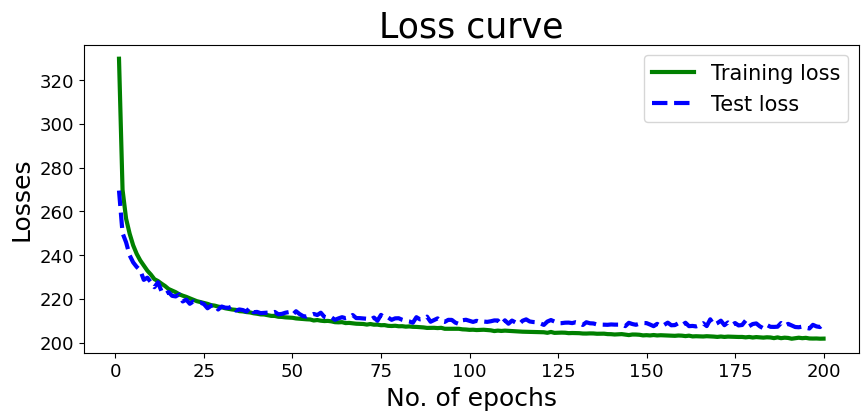

In [18]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(10, 4))
plt.plot(N, training_loss, 'g-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b--', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15);

# 12. Model prediction

In [19]:
cond_vae.eval()
y = torch.randint(low=0, high=len(test_dataset), size=(25,))
get_images = torch.cat([test_dataset[i][0][None, :] for i in y])
print('Reconstructing images for:\n', test_dataset.targets[y])

Reconstructing images for:
 tensor([3, 5, 4, 7, 8, 6, 4, 8, 9, 8, 1, 3, 9, 7, 2, 7, 0, 5, 8, 8, 3, 9, 3, 0,
        8])


In [20]:
get_reconstructs, _, _ = cond_vae.cpu()(get_images, test_dataset.targets[y])

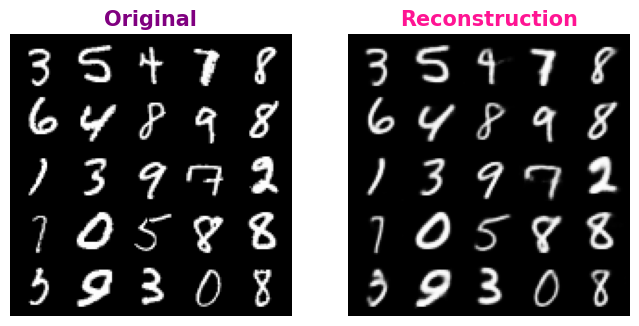

In [21]:
plt.figure(figsize=(8, 4))
img_grid = make_grid(get_images, nrow=5)
rec_grid = make_grid(get_reconstructs, nrow=5)
plt.subplot(1, 2, 1)
plt.imshow(img_grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Original', fontsize=15, fontweight='bold', color='purple')
plt.subplot(1, 2, 2)
plt.imshow(rec_grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Reconstruction', fontsize=15, fontweight='bold', color='deeppink');

# 13. Create images from noise conditioned on labels 

In [22]:
cond_vae.eval()
create_noise = torch.randn(25, 16)
create_labels = torch.randint(low=0, high=len(test_dataset.classes), size=(25,))
print('Creating images for:\n', create_labels)

Creating images for:
 tensor([1, 6, 4, 7, 0, 9, 5, 4, 6, 1, 6, 5, 9, 1, 1, 0, 3, 8, 5, 3, 8, 8, 7, 3,
        6])


In [23]:
concat = torch.cat([create_noise, cond_vae.embedding(create_labels)], dim=1)
sampled = cond_vae.decoder(concat.view(-1, 32, 1, 1))

In [24]:
gen_imgs = make_grid(sampled, nrow=5).permute(1, 2, 0)

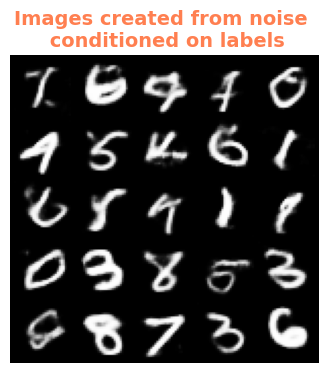

In [25]:
plt.figure(figsize=(14, 4))
plt.imshow(gen_imgs, cmap='gray')
plt.title('Images created from noise \n conditioned on labels', fontsize=14, fontweight='bold', color='coral')
plt.axis(False);